### 1. Prepare the spark environment

In [1]:
# Imports
from pyspark.sql import SparkSession 
from pyspark.sql import SQLContext

In [2]:
print(sc)

<SparkContext master=local[*] appName=PySparkShell>


In [3]:
# 1 - Spark Session (to work with spark)
spSession = SparkSession.builder.master("local").appName("SparkSQL").getOrCreate()

In [4]:
# 2 - Initialize SQLContext (to work with Spark SQL) 
sqlContext = SQLContext(sc)

### 2. Prepare the data 

In [5]:
# To grab a PARQUET file and create a dataframe out of it
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2021-02-23 12:17:19--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2021-02-23 12:17:19--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2021-02-23 12:17:20--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [7]:
# Put on a dataframe
df = spark.read.parquet('washing.parquet')

In [8]:
# Check how many rows we have got
df.count()

2058

In [9]:
# Now register the dataframe in the ApacheSparkSQL catalog so that we can query it using SQL
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

# 3. Plots

### BoxPlot
So let's visualize voltage using a box plot to get an idea on the value distribution of this parameter. First, we have to create a python list. Make sure you use the sample function in order to not blast your spark driver or plotting library.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#just print the 1st 15 elements
result_array[:15]

[235, 225, 224, 226, 230, 232, 227, 226, 221, 234, 250, 244, 236, 239, 238]

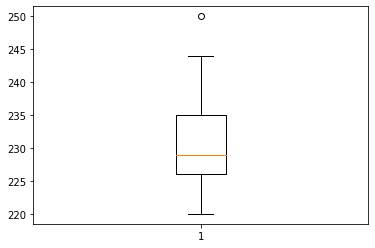

In [12]:
plt.boxplot(result_array)
plt.show()

### Run chart

Since we are dealing with time series data we want to make use of the time dimension as well. The least complex plots are run charts where the time domain (dimension) is represented at the horizontal x-axis and the y-axis shows the actual sensor value. Let's do this for voltage as wel

In [13]:
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808728916, 1547808776948, 1547808821976, 1547808827980, 1547808915092, 1547808921096, 1547808924097, 1547808951131, 1547808990168, 1547809002173, 1547809044214, 1547809086239, 1547809119261, 1547809134265, 1547809170308]
[222, 235, 230, 224, 238, 224, 225, 238, 232, 243, 227, 222, 223, 233, 226]


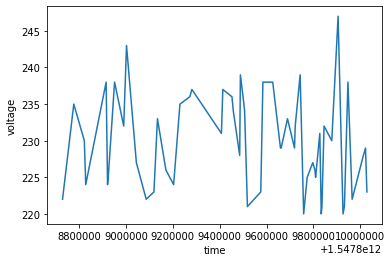

In [14]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

NOTE: But this time we want to only plot data worth of one hour. Therefore we first have to find out in which date range we have data available:

In [15]:
spark.sql("select min(ts),max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



Now lets repeat the previous steps but only show data for hour. We've found out the low and high boundary of data available and we know that "ts" stand for "timestamp". Timestamp are the number of millisecons passed since the 1st of Jan. 1970. You can also use an online tool like http://www.epochconverter.com/ to convert these. But for now just an interval of 60 minutes (10006060)=3600000 within the range above (note that we have removed the sample function because the data set is already reduced)

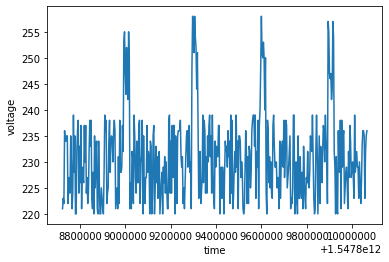

In [16]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

As we can see we are not only able to spot the outliers but also see a time pattern of these outliers occuring which can be used for further downstream analysis. Again your brain was already capable of spotting the pattern.

### ScatterPlot

Now we've plotted a maximum of two dimensions at a time, let's go for three in a so-called 3D scatter plot. Again we have to create python lists (with applied sampling if necessary) from three properties of our data.

In [17]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))

result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()

result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()

result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

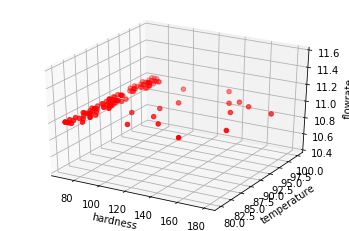

In [18]:
# Once done it is very simple to import the necessary library and create a scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()


We will notice that the individual points resemble in some sort of plane. But this is not a surprise. Actually we can draw the following conclusions from the plot:

- most of the data points are lying around hardness 60-80, temperature 80-100 and flowrate 80-100
- there are some outliers, especially when it comes to the range of hardness 100-200
- the data follows some narrow boundaries

### Histogram
So lets double-check what's going on with hardness since it seems that it really sticks around 60-80 and very seldom creates values above that. We can use a histogram for that which bins together certain value ranges and counts the frequency of occurences of values within this range. Those frequencies are ordered and shown as a bar diagram, so let's plot it:

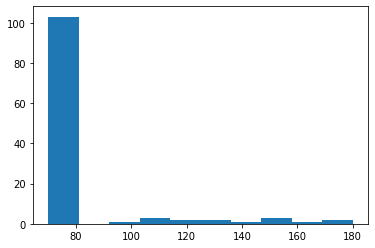

In [19]:
plt.hist(result_array_hardness)
plt.show()

Our assumption was correct, nearly all values are around 60-80 with very less values about that threshold!

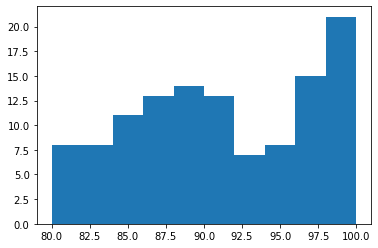

In [20]:
# And
plt.hist(result_array_temperature)
plt.show()

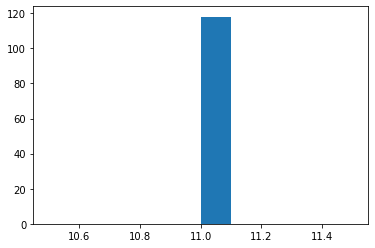

In [21]:
# and 
plt.hist(result_array_flowrate)
plt.show()

# End